# Detección de anomalías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

Un valor atípico es una observación diferente a las otras observaciones. Es raro, distinto o no encaja de alguna manera. También se le llama anomalías.
Tipo de outliers:
* Univariate: solo tenemos en cuenta una variable.
* Multivariate: tenemos en cuenta n-variables.


In [2]:
# Detección de outliers univariable

# cargamos el dataset de heart-disease https://archive.ics.uci.edu/ml/datasets/Heart+Disease
df_1 = pd.read_csv("heart.csv")
df_1.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Isolation forest

[Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on.](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest)

Es un algoritmo para detectar valores atípicos. Divide los datos utilizando un conjunto de árboles y proporciona una puntuación de anomalía que indica qué tan aislado está el punto en la estructura encontrada. 

La puntuación de anomalía se utiliza para diferenciar los valores atípicos de las observaciones normales.

Un concepto importante en este método es el número de aislamiento. El número de aislamiento es el número de divisiones necesarias para aislar un punto de datos. 

El funcionamiento general del algoritmo es de la siguiente manera:
1. Dado un dataset se selecciona una muestra aleatoria de los datos y se asigna a un árbol binario.
2. La ramificación del árbol comienza seleccionando una característica aleatoria del dataset de las `N`disponibles. A continuación, las ramas se generan a partir de un valor aleatorio entre el mínimo y máximo de dicha característica.
3. Si el valor de un punto de datos es menor que el umbral seleccionado, va a la rama izquierda o a la derecha. Y así un nodo se divide en ramas izquierda y derecha.
4. Este proceso desde el paso 2 continúa recursivamente hasta que cada punto de datos está completamente aislado o hasta que se alcanza la profundidad máxima (si está definida).
5. Los pasos anteriores se repiten para construir árboles binarios aleatorios. 

Una vez construidos los árboles hay que detectar las anomalías. La idea principal es que se requieren menos divisiones para aislar un valor atípico que para aislar un valor no atípico, es decir, un valor atípico tiene un **número de aislamiento** más bajo en comparación con un punto no atípico. Por lo tanto, **un punto de datos se define como un valor atípico si su número de aislamiento es inferior al umbral**.

En la propuesta original de Lui. et al 2008, definen **anomaly score**, en base a las longitudes de los caminos: los caminos más cortos indican que tenemos anomalías, mientras que los caminos más largos muestran que hay observaciones normales. 

Nota: la implementación de Isolation Forest de scikit-learn introdujo una modificación del anomaly score. Los valores atípicos están indicados por puntuaciones negativos, mientras que la puntución positivo implica que tenemos valores internos. Y además, introduce el concepto 'contamination'.

- If ‘auto’, the threshold is determined as in the original paper.
- If float, the contamination should be in the range (0, 0.5].

Si utilizamos nuestro propio valor de contamination podemos decir que el umbral se define en función del porcentaje estimado de valores atípicos en los datos.

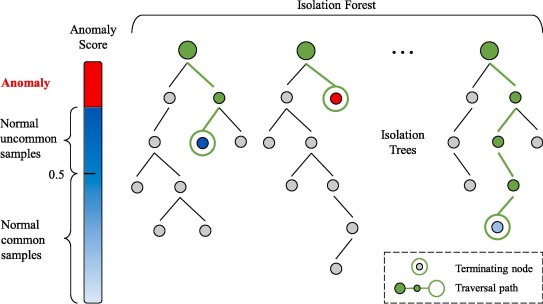

Documentación de sklearn sobre Isolation Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

Explicación de Isolation Forest en scikit, https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest


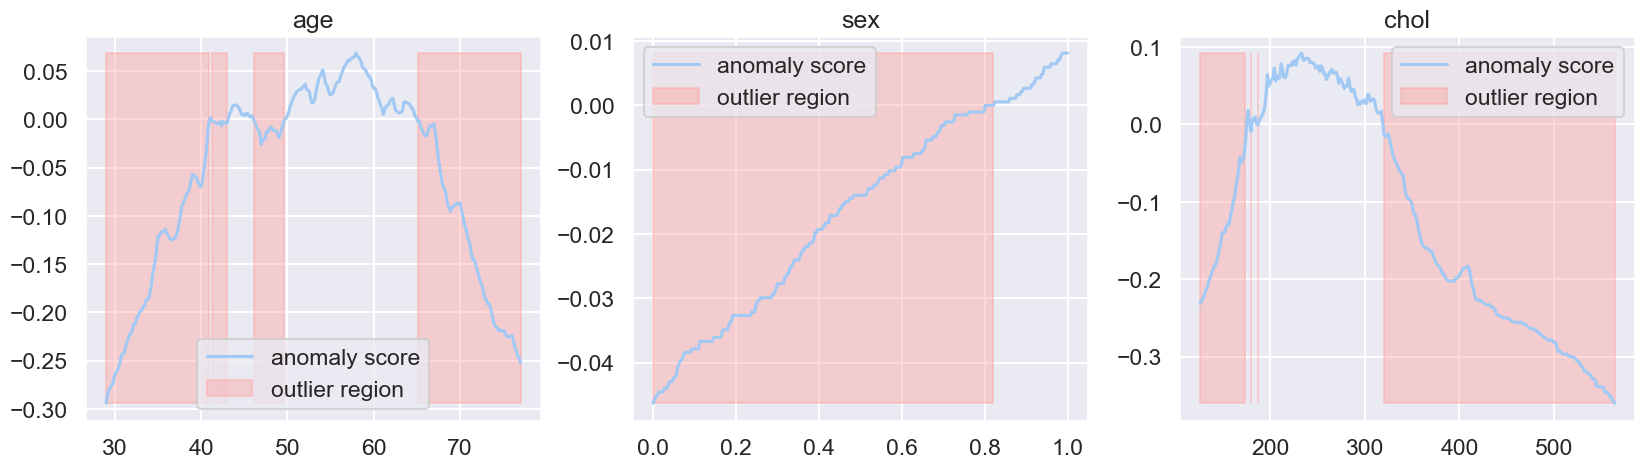

In [3]:
from sklearn.ensemble import IsolationForest
#The required columns
# cols = ['trestbps', 'chol', 'thalach']
cols = ['age','sex','chol']
# cols = ['chol']


#Plotting the sub plot
fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df_1[column].values.reshape(-1,1))

    xx = np.linspace(df_1[column].min(), df_1[column].max(), len(df_1)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    df_1['anomaly'] = outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [4]:
# Hemos añadido una nueva columna 'anomaly' que nos indica el resultado de IF
# -1 en la columna indica que es anomalía, 1 indica valor normal
df_1

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,anomaly
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,-1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,-1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,-1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,-1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,-1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,-1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,-1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1,-1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1,-1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1,-1


Para ampliar conocimientos de Isolation Forest y entender sus limitaciones y una alternativa para solventarlas, recomiendo la lectura del siguiente artículo, S. Hariri, M. C. Kind and R. J. Brunner, "Extended Isolation Forest," in _IEEE Transactions on Knowledge and Data Engineering_, vol. 33, no. 4, pp. 1479-1489, 1 April 2021, doi: 10.1109/TKDE.2019.2947676. https://ieeexplore.ieee.org/abstract/document/8888179

# Multivariate outliers

## Local Outlier Factor Method(LOF)

Breunig, Kriegel, Ng, and Sander (2000) LOF: identifying density-based local outliers. Proc. ACM SIGMOD https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf


LOF utiliza la detección de valores atípicos basada en la densidad para identificar valores atípicos locales, puntos que son valores atípicos con respecto a su vecindario local, en lugar de con respecto a la distribución global de datos. 

Cuanto mayor sea el valor de LOF para una observación, más anómala será la observación.

In [5]:
# En el dataset de enfermedad cardíaca vamos a observar las variables edad y colesterol

clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
X = df_1[['age','chol', 'sex']].values
# X = df_1[['age','chol']].values
y_pred = clf.fit_predict(X)


In [6]:
# Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score
clf.negative_outlier_factor_

array([-0.99590908, -1.15102828, -1.02741356, -0.97567394, -1.69018057,
       -1.0331231 , -1.02358318, -1.02977726, -0.99111719, -1.34368785,
       -0.97176957, -1.01402668, -0.99281722, -1.00061926, -1.00019725,
       -0.97121611, -1.40639568, -1.01949477, -1.03733704, -1.05300918,
       -0.98410487, -1.00115509, -1.0422649 , -0.98743183, -1.0497518 ,
       -1.0783488 , -0.98018135, -1.21224718, -3.2751389 , -1.00070013,
       -1.03896208, -1.27284349, -1.01051584, -0.99412145, -0.96965088,
       -1.18840375, -1.04292125, -0.96976985, -1.00551491, -1.83416261,
       -1.0690627 , -0.98987125, -0.99832548, -0.98508374, -1.21571475,
       -1.18846706, -0.99910315, -1.00107754, -0.97708711, -0.9678596 ,
       -1.00194769, -1.04871817, -0.98369305, -1.95865437, -0.99835812,
       -0.98663236, -0.98605684, -1.02463156, -1.23741771, -1.03474553,
       -1.0673366 , -1.07088076, -1.07974663, -1.02348859, -0.97620111,
       -1.21055937, -0.97676625, -0.99205169, -1.00874923, -0.99

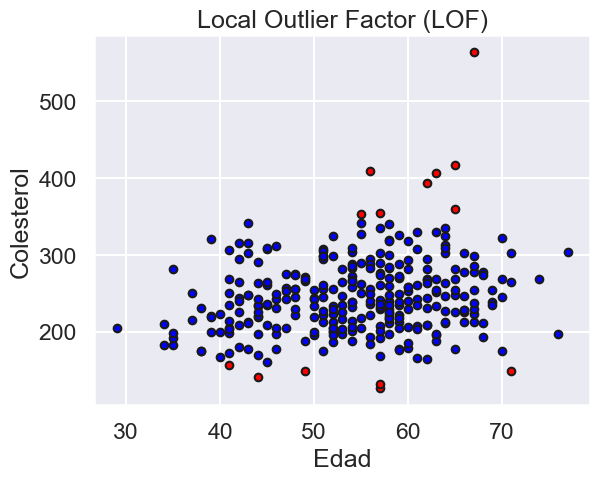

In [7]:
in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")

# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                edgecolor = 'k', s = 30)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                edgecolor = 'k', s = 30)
plt.axis('tight')
plt.xlabel('Edad');
plt.ylabel('Colesterol');

plt.show()

Para ampliar la información sobre LOF se recomienda leer:
- Documentación scikit: [https://scikit-learn.org/stable/modules/outlier_detection.html#id1](Local Outlier Factor)
- Ejemplo en Python: [Outlier detection with Local Outlier Factor (LOF)](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py)


